# Tube segmentation

In [1]:
from brainlit.utils import session
from brainlit.feature_extraction import *
import napari

In [2]:
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
sess = session.NeuroglancerSession(url=url, url_segments=url+"_segments", mip=0)
SEGLIST=[101,103,106,107,109,11,111,112,115,11,12,120,124,126,127,129,13,132,133,136,137,14,140,141,142,143,144,145,146,147,149,150]

In [3]:
%%capture
nbr = NeighborhoodFeatures(url=url, size=3, offset=[50,50,50], segment_url=url+"_segments")
nbr.fit(seg_ids=SEGLIST, num_verts=1000, file_path='demo', batch_size=1000)

In [3]:
import glob, feather
feathers = glob.glob('*.feather')


for count, feather_file in enumerate(feathers):
    if count == 0:
        data = feather.read_dataframe(feather_file)
    else:
        df = feather.read_dataframe(feather_file)
        data = pd.concat([data, df])
data.shape

(8000, 346)

In [4]:
data.head()

,Segment,Vertex,Label,0,1,2,3,4,5,6,...,333,334,335,336,337,338,339,340,341,342
0,7,250,1,12066,11944,11971,11966,11950,12077,12035,...,12208,12017,12106,12533,12922,12731,12200,12158,12148,12179
1,7,250,0,11965,11999,11910,11998,12033,12079,12010,...,11915,11850,11835,12098,11893,11950,11929,12010,11813,12028
2,7,251,1,12015,12084,12064,12052,11873,11936,11764,...,12123,12030,12189,11854,12066,12106,12088,12071,12065,12141
3,7,251,0,11830,11966,12040,11995,11937,12003,11935,...,12014,12029,12220,11842,11864,11965,12038,11977,11999,12076
4,7,252,1,11756,11743,11972,12191,11981,12085,11950,...,11810,11897,11971,11748,11905,11931,11847,11830,11808,11895


In [5]:
from sklearn.preprocessing import StandardScaler
X = data.iloc[:, 3:]
X = StandardScaler().fit_transform(X)

y = data["Label"]

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
clf = MLPClassifier(hidden_layer_sizes=4, activation="logistic", alpha=1, max_iter=1000).fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

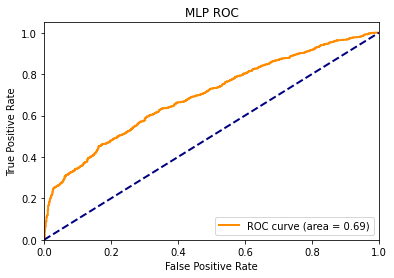

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC')
plt.legend(loc="lower right")
plt.show()

In [8]:
from brainlit.feature_extraction.neighborhood import subsample

In [9]:
from sklearn.linear_model import LogisticRegression
X_center = X[:, 172].reshape(-1,1)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, stratify=y, random_state=1)
clf = LogisticRegression(random_state=1, max_iter=2000).fit(Xc_train, yc_train)
yc_score = clf.predict_proba(Xc_test)

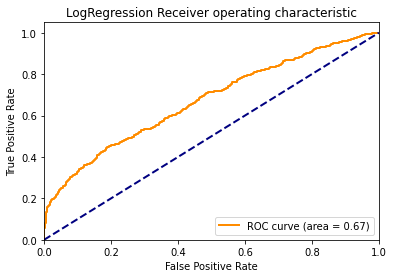

In [11]:
fpr_c, tpr_c, _ = roc_curve(yc_test, yc_score[:,1])
roc_auc_c = auc(fpr_c, tpr_c)

plt.figure()
lw = 2
plt.plot(fpr_c, tpr_c, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_c)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogRegression Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()